# Introduction 
## The goal of this kernel is not creating beautiful visualization , rather to try to understand what causes factors cause more participation , involvement with SO website and what type of respondents feel as insiders of the community.
* ##   The first part is some basic Exploratory Analysis
* ## The Second part I have created a target value called *Ease of Participation* that incorporates participation,involvement , satisfaction with SO community. I have used *XGBoost* to Get the important variable in deciding the target

# PART I

# General EDA

In [8]:
%matplotlib inline

In [9]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import xgboost
import operator

# Reading in Data

In [10]:
df1 = pd.read_csv('../input/survey_results_schema.csv')

In [11]:
df2 = pd.read_csv('../input/survey_results_public.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Some General Descriptive Statistics

## Hobby Coders

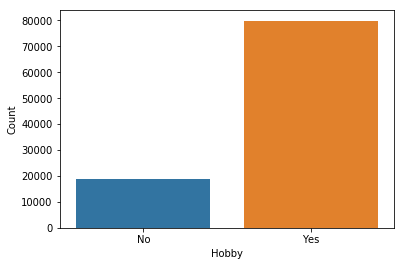

In [12]:
plt.figure(1)
for_plot = df2.groupby(["Hobby"]).size()
for_plot = for_plot.reset_index()
sns.barplot(x = for_plot["Hobby"] , y = for_plot[0])
plt.ylabel("Count")
plt.show()

## Open Source People

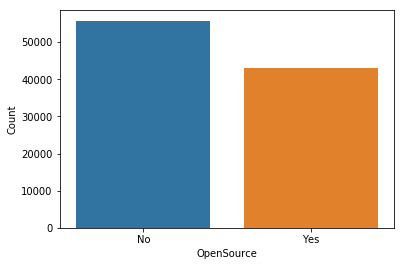

In [13]:
plt.figure(1)
for_plot = df2.groupby(["OpenSource"]).size()
for_plot = for_plot.reset_index()
sns.barplot(x = for_plot["OpenSource"] , y = for_plot[0])
plt.ylabel("Count")
plt.show()

## Filtering respondents based on whether they use StackOverflow as their Learning Resource called Stack Learners

In [14]:
df2["is_stack_learner"] = df2["SelfTaughtTypes"].str.contains("Stack Overflow")

### Out of the ones using StackOverflow as learning resource 40% participate less than once per month, 25% weekly few times, 15% Never participated

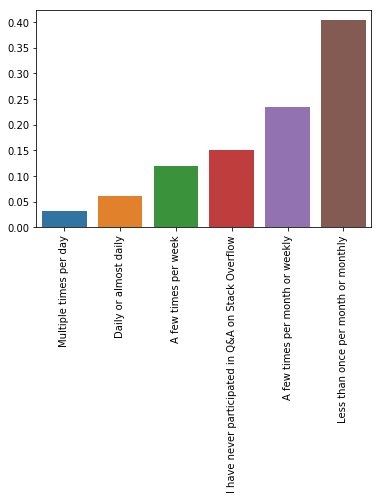

In [15]:
for_plot = df2[-pd.isnull(df2["is_stack_learner"])]
for_plot = for_plot[for_plot["is_stack_learner"]]
for_plot = for_plot.groupby(["StackOverflowParticipate"]).size().reset_index()
for_plot[0] = for_plot[0].apply(lambda x : x/for_plot[0].sum())
plt.figure(1)
D = zip(for_plot["StackOverflowParticipate"], for_plot[0])
D = sorted( list(D) , key = lambda x : x[1])
plt.figure(1 , figsize = (30,30))
x_val = [x[0] for x in D]
y_val = [x[1] for x in D]
sns.barplot(x_val , y_val)
plt.xticks(rotation = 90)
plt.show()
#So about 55% of users who use stack overflow for learning end up participating very rarely. This subset must be 
#done with further investigation

## How many Stack learners consider themsevles to be the members of the Site

### Approx 40% of Stack learners dont cosider / not sure themselves as members

In [14]:
for_plot = df2[-pd.isnull(df2["is_stack_learner"])]
for_plot = for_plot[for_plot["is_stack_learner"]]
for_plot = for_plot.groupby(["StackOverflowConsiderMember"]).size().reset_index()
for_plot[0] = for_plot[0].apply(lambda x : x/for_plot[0].sum())
plt.figure(1)
D = zip(for_plot["StackOverflowConsiderMember"], for_plot[0])
D = sorted( list(D) , key = lambda x : x[1])
plt.figure(1 , figsize = (30,30))
x_val = [x[0] for x in D]
y_val = [x[1] for x in D]
sns.barplot(x_val , y_val)
plt.show()

## Do Stack  learners visit SO daily ?? Looks like that. Even I do visit daily

In [15]:
for_plot = df2[-pd.isnull(df2["is_stack_learner"])]
for_plot = for_plot[for_plot["is_stack_learner"]]
for_plot = for_plot.groupby(["StackOverflowVisit"]).size().reset_index()
for_plot[0] = for_plot[0].apply(lambda x : x/for_plot[0].sum())
plt.figure(1)
D = zip(for_plot["StackOverflowVisit"], for_plot[0])
D = sorted( list(D) , key = lambda x : x[1])
plt.figure(1 , figsize = (30,30))
x_val = [x[0] for x in D]
y_val = [x[1] for x in D]
sns.barplot(x_val , y_val)
plt.xticks(rotation = 90)
plt.show()

## Lets consider only  Daily visitors and Multiple time daily visitors, But what proportion of them participate daily?

### Only 15% of frequent visitors participate as frequently as they visit.

In [16]:
for_plot = df2[-pd.isnull(df2["is_stack_learner"])]
for_plot = for_plot[for_plot["is_stack_learner"]]
for_plot = for_plot[(for_plot["StackOverflowVisit"] == "Daily or almost daily") | (for_plot["StackOverflowVisit"] == "Multiple times per day")]
for_plot = for_plot.groupby(["StackOverflowParticipate"]).size().reset_index()
for_plot[0] = for_plot[0].apply(lambda x : x/for_plot[0].sum())
D = zip(for_plot["StackOverflowParticipate"], for_plot[0])
D = sorted( list(D) , key = lambda x : x[1])
plt.figure(1 , figsize = (5,5))
x_val = [x[0] for x in D]
y_val = [x[1] for x in D]
sns.barplot(x_val , y_val)
plt.xticks(rotation = 90)
plt.show()

# PART II 

# * Ease of Participation. *
### A Target Value to Measure how accessible or easy is to be involved with StackOverflow

## Columns we are intersested in to form target -->  Ease of Participation

In [19]:
tempo = df1[(df1["Column"].str.contains("StackOverflow")) | (df1["Column"].str.contains("Hypothetical"))].reset_index()

In [22]:
tempo

 ### * Negative 1.5* Weight given to 'Hypothetical Tools2' Column as it asks respondents whether they prefer private area for new programmer. A higher score for this shows the lesser easy accessibilty of SO to new programmers

In [24]:
tempo.loc[9][2]  #Hypothetical Tools2

###  *Positive 1 *, to "StackOverflowRecommend" column because if you recommend you would surely like it. But doesnt show much of participation ease as even if you are only a visitor, you may recommend the site. Therefore weight of 1.

In [25]:
tempo.loc[0][2] #StackOverflowRecommend

### Positive 0.25 , given to "StackOverflowHasAccount" because account only shows a little to how much you participate though it is positive in some sense

In [26]:
tempo.loc[2][2] #StackOverflowHasAccount

### Positive 2 , given to  "StackOverflowParticipation" This is a very apt. measure for Ease of Participation on the site

In [27]:
tempo.loc[3][2] #StackOverflowParticipation

### Positive 1.5, to StackOverflowConsiderMember Those who consider probably like the overall community and feel as an insider.

In [28]:
tempo.loc[7][2] #Positive 1.5

##  Preparing the Target Ease of Participation and Some Mapping with all weights and scaling appropriately

In [29]:
code  =  {'Extremely interested' :4 , 'Very interested' :3 , 'Somewhat interested' : 2 , 'A little bit interested' : 1 , 'Not at all interested' :0 }

In [30]:
code_reco = {'10 (Very Likely)' :4 , '7' :3 , '9' : 4 , '8' : 3,  '0' : 0 , '1' : 0 , '6' : 2 , '5' : 2 , '4' : 1.5, '3':1 , '2': 1 }

In [38]:
df2["Ease of Participation"] = -1.5 * df2["HypotheticalTools2"].map(code) #-1.5 weight

In [40]:
recommend = df2["StackOverflowRecommend"].map(code_reco)

In [41]:
df2["Ease of Participation"] += 1 * recommend # +1 weight

In [44]:
account = df2["StackOverflowHasAccount"].map({'Yes' : 1 , 'No' : 0 , 'I\'m not sure / I can\'t remember' : 0}) 

In [45]:
df2["Ease of Participation"] += account *4 * 0.25   #+0.25 weight ; Scaled to 0-4

In [46]:
participate_map = {'I have never participated in Q&A on Stack Overflow':0, 'Less than once per month or monthly' :1 , 'A few times per month or weekly' : 2 ,'A few times per week' : 3 ,'Daily or almost daily' : 4, 'Multiple times per day' : 4  }

In [47]:
participate_map

In [48]:
participates = df2["StackOverflowParticipate"].map(participate_map)

In [49]:
df2["Ease of Participation"] += (participates * 2) #+2 weight

In [50]:
memberso = df2["StackOverflowConsiderMember"].map({'Yes' : 1 , 'No' : 0 , 'I\'m not sure' : 0}) 

In [51]:
df2["Ease of Participation"] += memberso * 4 * 1.5 #+1.5 weight ; scaled to 0-4

## Ease of Participation is higher for Stack Learners. Which is intuitive

In [53]:
plt.figure(1)
for_plot = df2[-pd.isnull(df2["is_stack_learner"])]
sns.boxplot(x = for_plot["is_stack_learner"] , y = for_plot["Ease of Participation"])# , order = meds)
plt.xticks(rotation = 90)
plt.show()


## Country wise mean Ease of Participation Score

In [54]:
for_plot = df2.groupby(["Country"])["Ease of Participation"].mean().reset_index().dropna()
plt.figure(7 , figsize= (30,30))
#sns.barplot(x = for_plot["Country"] , height = for_plot["Ease of Participation"])
#plt.xticks(rotation = 90)
D = zip(for_plot["Country"], for_plot["Ease of Participation"])
D = sorted( list(D) , key = lambda x : x[1])
plt.figure(1 , figsize = (30,30))
x_val = [x[0] for x in D]
y_val = [x[1] for x in D]
sns.barplot(x_val , y_val)
plt.xticks(rotation = 90)
plt.show()

## Ease of Participation different for Windows users? Not much

In [56]:
df2["is_windows"] = (df2["OperatingSystem"] == "Windows")
plt.figure(1)
plt.figure(1)
sns.boxplot(x = df2["is_windows"] , y = df2["Ease of Participation"])# , order = meds)
plt.xticks(rotation = 90)
plt.show()


## Ease of Participation is higher for non-students

In [57]:
plt.figure(1)
sns.boxplot(x = df2["Student"] , y = df2["Ease of Participation"])
plt.show()

## As expected the Ease of Participation if least for 0-2 years coding experience and increases with the number years

In [58]:
plt.figure(1)
sns.boxplot(x = df2["YearsCoding"] , y = df2["Ease of Participation"])
plt.xticks(rotation = 90)
#pol.set_xticklabels(rotation=90)
plt.show()

## Ease of Participation different for Hobby users? Higher for Hobbyists

In [62]:
plt.figure(1)
sns.boxplot(x = df2["Hobby"] , y = df2["Ease of Participation"])# , order = meds)
plt.xticks(rotation = 90)
#pol.set_xticklabels(rotation=90)
plt.show()

## Number of Monitors ? 4+ , monitor users have highest median score

In [64]:
#Number of Monitors??
plt.figure(1)
sns.boxplot(x = df2["NumberMonitors"] , y = df2["Ease of Participation"])# , order = meds)
plt.xticks(rotation = 90)
#pol.set_xticklabels(rotation=90)
plt.show()

## Ease of Participation is higer for both least Hours on Computer and most Hours on Computer per day

In [66]:
plt.figure(1)
sns.boxplot(x = df2["HoursComputer"] , y = df2["Ease of Participation"])# , order = meds)
plt.xticks(rotation = 90)
#pol.set_xticklabels(rotation=90)
plt.show()

## Multiple Choice encoding, directly picked from NanoMathias [here](http://https://www.kaggle.com/nanomathias/predicting-r-vs-python)

In [67]:

MULTIPLE_CHOICE = [
    'CommunicationTools','EducationTypes','SelfTaughtTypes','HackathonReasons', 
    'DatabaseWorkedWith','DatabaseDesireNextYear','PlatformWorkedWith',
    'PlatformDesireNextYear','Methodology','VersionControl',
    'AdBlockerReasons','AdsActions','ErgonomicDevices','Gender',
    'SexualOrientation','RaceEthnicity', 'LanguageWorkedWith'
]
for c in MULTIPLE_CHOICE:
    # Check if there are multiple entries in this column
    temp = df2[c].str.split(';', expand=True)

    # Get all the possible values in this column
    new_columns = pd.unique(temp.values.ravel())
    for new_c in new_columns:
        if new_c and new_c is not np.nan:
            
            # Create new column for each unique column
            idx = df2[c].str.contains(new_c, regex=False).fillna(False)
            df2.loc[idx, f"{c}_{new_c}"] = 1

    # Info to the user
    print(f">> Multiple entries in {c}. Added {len(new_columns)} one-hot-encoding columns")


### Ease of Participation for different Languages (Only Stack Learners Taken)
#### More analysis can be further done, based on classification of languages

In [68]:
for_plot = df2
for_plot[[cols for cols in for_plot.columns.values if re.search('^Language\S+_' , cols)]] = for_plot[[cols for cols in for_plot.columns.values if re.search('^Language\S+_' , cols)]].fillna(0)
for_plot = for_plot[for_plot[[cols for cols in for_plot.columns.values if re.search('^Language\S+_' , cols)]].sum(axis=1)!=0]
for_plot = for_plot[-pd.isnull(for_plot["is_stack_learner"])]
for_plot = for_plot[for_plot["is_stack_learner"]] #Those who learn using stack overflow, probably the lanugage , therefore subsettin
for_plot = for_plot[[cols for cols in for_plot.columns.values if re.search('^Language\S+_' , cols)] + ['Ease of Participation']]
D = {}
for i in for_plot.columns.values[:-1]:
    D[i] = for_plot[for_plot[i] == 1]["Ease of Participation"].mean()
D = sorted(D.items(), key=operator.itemgetter(1))
plt.figure(1 , figsize = (30,30))
x_val = [x[0] for x in D]
y_val = [x[1] for x in D]
sns.barplot(x_val , y_val)
plt.xticks(rotation = 90)
plt.show()

### Education Types affects Ease?? Learners who have taught themselves by contributing to OSS have higher socre 

In [70]:
for_plot = df2
for_plot[[cols for cols in for_plot.columns.values if re.search('^EducationTypes_' , cols)]] = for_plot[[cols for cols in for_plot.columns.values if re.search('^EducationTypes_' , cols)]].fillna(0)    
for_plot = for_plot[for_plot[[cols for cols in for_plot.columns.values if re.search('^EducationTypes_' , cols)]].sum(axis=1)!=0]
#Those who learn using stack overflow, probably the lanugage , therefore subsettin
for_plot = for_plot[[cols for cols in for_plot.columns.values if re.search('^EducationTypes_' , cols)] + ['Ease of Participation']]
D = {}
for i in for_plot.columns.values[:-1]:
    D[i] = for_plot[for_plot[i] == 1]["Ease of Participation"].mean()
D = sorted(D.items(), key=operator.itemgetter(1))
plt.figure(1 , figsize = (5,5))
x_val = [x[0] for x in D]
y_val = [x[1] for x in D]
sns.barplot(x_val , y_val)
plt.xticks(rotation = 90)
plt.show()

### Version Control-wise comparison. Least for Non-users and Copy_pasters. Expected.

In [71]:
for_plot = df2
for_plot[[cols for cols in for_plot.columns.values if re.search('^VersionControl_' , cols)]] = for_plot[[cols for cols in for_plot.columns.values if re.search('^VersionControl_' , cols)]].fillna(0)
for_plot = for_plot[for_plot[[cols for cols in for_plot.columns.values if re.search('^VersionControl_' , cols)]].sum(axis=1)!=0]
for_plot = for_plot[[cols for cols in for_plot.columns.values if re.search('^VersionControl_' , cols)] + ['Ease of Participation']]
D = {}
for i in for_plot.columns.values[:-1]:
    D[i] = for_plot[for_plot[i] == 1]["Ease of Participation"].mean()
D = sorted(D.items(), key=operator.itemgetter(1))
plt.figure(1 , figsize = (5,5))
x_val = [x[0] for x in D]
y_val = [x[1] for x in D]
sns.barplot(x_val , y_val)
plt.xticks(rotation = 90)
plt.show()

### Not much difference in methodology of programming

In [72]:
for_plot = df2
for_plot[[cols for cols in for_plot.columns.values if re.search('^Methodology_' , cols)]] = for_plot[[cols for cols in for_plot.columns.values if re.search('^Methodology_' , cols)]].fillna(0)
for_plot = for_plot[for_plot[[cols for cols in df2.columns.values if re.search('^Methodology_' , cols)]].sum(axis=1)!=0]
#Those who learn using stack overflow, probably the lanugage , therefore subsettin
for_plot = for_plot[[cols for cols in for_plot.columns.values if re.search('^Methodology_' , cols)] + ['Ease of Participation']]
D = {}
for i in for_plot.columns.values[:-1]:
    D[i] = for_plot[for_plot[i] == 1]["Ease of Participation"].mean()
D = sorted(D.items(), key=operator.itemgetter(1))
plt.figure(1 , figsize = (5,5))
x_val = [x[0] for x in D]
y_val = [x[1] for x in D]
sns.barplot(x_val , y_val)
plt.xticks(rotation = 90)
plt.show()

### StackOverflow Enterprise stands out in Communication Tools

In [73]:
for_plot = df2
for_plot[[cols for cols in for_plot.columns.values if re.search('CommunicationTools_' , cols)]] = for_plot[[cols for cols in for_plot.columns.values if re.search('CommunicationTools_' , cols)]].fillna(0)
for_plot = for_plot[for_plot[[cols for cols in for_plot.columns.values if re.search('CommunicationTools_' , cols)]].sum(axis=1)!=0]
#Those who learn using stack overflow, probably the lanugage , therefore subsettin
for_plot = for_plot[[cols for cols in for_plot.columns.values if re.search('CommunicationTools_' , cols)] + ['Ease of Participation']]
D = {}
for i in for_plot.columns.values[:-1]:
    D[i] = for_plot[for_plot[i] == 1]["Ease of Participation"].mean()
D = sorted(D.items(), key=operator.itemgetter(1))
plt.figure(1 , figsize = (5,5))
x_val = [x[0] for x in D]
y_val = [x[1] for x in D]
sns.barplot(x_val , y_val)
plt.xticks(rotation = 90)
plt.show()

### Excluding columns with more than 15 categories

In [76]:
uniqueness = []
for i in df2.columns.values[1:]:
    if len(pd.unique(df2[i])) > 15:
        continue
        #print(i)
    elif "StackOverflow" in i:
        continue
        #print("TARGET --->", i)
    elif "Hypo" in i:
        continue
        #print("TARGET --->", i) 
    else:
        uniqueness.append(i)

## Getting columns ready for Xgboost

In [77]:
for_tree = df2
for_tree = for_tree[[cols for cols in uniqueness]]
for_tree = for_tree.drop("SexualOrientation", axis = 1)
listo = list(for_tree.dtypes == object)
for_tree2 = for_tree
for i,col in enumerate(for_tree.columns.values):
    if listo[i] == True:
        new_columns = pd.get_dummies(for_tree[col])
        for new_c in new_columns:
            #print(f"{col}_{new_c}")
            if new_c and new_c is not np.nan:
                for_tree2 = pd.concat([for_tree2, new_columns[new_c]] , axis = 1)
                for_tree2.columns.values[-1] = f"{col}_{new_c}"
        for_tree2 = for_tree2.drop(col,axis = 1)

In [78]:
for_tree2.head()

## Removing NaN's for target

In [80]:
final_tree = pd.concat([for_tree2 , df2["Ease of Participation"]] , axis = 1)
final_tree = final_tree[-pd.isnull(final_tree["Ease of Participation"])]

In [81]:
final_tree.head(8)

In [82]:
import xgboost as xgb
# read in data
dtrain = xgb.DMatrix(final_tree.iloc[:,:-1] , label= final_tree["Ease of Participation"])

In [83]:
dtrain.get_label()

## Run in XGboost

In [84]:
# specify parameters via map
param = {'max_depth':1, 'eta':0.01, 'silent' : 0 , 'objective':'reg:linear' , 'subset' : 0.5 }
num_round = 500
bst = xgb.train(param, dtrain, num_round)

## Make Predictions

In [85]:
dtest = xgb.DMatrix(final_tree.iloc[:,:-1])
preds = bst.predict(dtest)

## Feature Importance 

In [86]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, max_num_features=50, height=0.8, ax=ax)
plt.show()

# Top 4 Features.  Although some are surprising
## 1.  OpenSource Users
## 2. Respondents who strongly Disagree that they are "not" as good as their peers
## 3. Years Coding Professionally (0-2)
## 4. Years Coding (0-2)

## To be done
1. Better weighting stratergy to prepare target Ease of Participation
2. Clustering Languages into categories and looking for insights
3. Fine-Tuning XGBoost better
4. Suggesstions in the comments